## Integrated Online Stationary Algorithm

**Author: D.Kufel**

**08/21/2019**

*Completed at IPAM, University of Califronia Los Angeles; RIPS2019 programme working on the Alibaba project*

**This is the implementation of the integrated online stationary algorithm developed for the generalized online matching problem. The integrated algorithm merges online gradient descent and upper confidence bound algorithm in the context of the online product recommendation. See: https://arxiv.org/abs/1911.07409 for details**

ReadMe: 

1. The first two cells are to run the online stationary code. They require files generated from the other jupyter notebook called generating_past_and_future_data.ipynb. 
2. The rest of the cells is to plot certain statistics from the simulation.
3. The last paragraph runs the offline code for benchmark of the online.

Commands %matplotlib notebook is for interactive plots. %%capture is to shut all the print statements in a given cell

In [2]:
%matplotlib notebook

In [3]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

m=5 #number of customer types
d=4 #number of items

#Loading the past/future customer arrivals
##################
pastdata_rewards=np.load('pastcustomerdata_beta_rewards.npy')
pastdata_type=np.load('pastcustomerdata_beta_customertype.npy')

newdata_rewards=np.load('newcustomerdata_beta_rewards.npy')
newdata_type=np.load('newcustomerdata_beta_customertype.npy')
##################
N=newdata_rewards.shape[0] #number of newly arriving customers

#np.random.seed(20)

def f_k(Lambda):
    #Dual problem objective function
    star=0
    for j in range(0,m):
        pj=prob_type[j] #selected row of pij matrix - for a given customer type j
        pjmax=np.max(pj)
        if pjmax==0:
            pjmax=np.min(prob_type[prob_type>0])
        #print(pjmax)
        a=np.max(pj*(r-Lambda)/(pjmax*mu))
        modtermj=a+np.log(np.sum(np.exp(pj*(r-Lambda)/(pjmax*mu)-a)))
        starj=modtermj*arrival_rates[j]/np.sum(arrival_rates)*pjmax
        star+=starj
    return mu*star+np.dot(Lambda,budget)/N


def true_dual(Lambda):
    #Dual problem objective function
    star=0
    for j in range(0,m):
        pj=true_prob_type[j] #selected row of pij matrix - for a given customer type j
        pjmax=np.max(pj)
        if pjmax==0:
            pjmax=np.min(prob_type[prob_type>0])
        #print(pjmax)
        a=np.max(pj*(r-Lambda)/(pjmax*mu))
        modtermj=a+np.log(np.sum(np.exp(pj*(r-Lambda)/(pjmax*mu)-a)))
        starj=modtermj*arrival_rates[j]/np.sum(arrival_rates)*pjmax
        star+=starj
    return mu*star+np.dot(Lambda,budget)/N


def partialderivative(Lambda,i,deltay):
    #Calculating partial derivative of the dual problem objective function w.r.t. particular item
    y=np.copy(Lambda)
    y[i]=y[i]+deltay
    fk_y=f_k(y)
    fk_x=f_k(Lambda)
    return (fk_y-fk_x)/deltay


def explicitpartialderivative(Lambda,i):
    star=0
    for j in range(0,m):
        pj=prob_type[j]
        pjmax=np.max(pj)
        if pjmax==0:
            pjmax=np.min(prob_type[prob_type>0])
        a=np.max(pj*(r-Lambda)/(pjmax*mu))
        starj=arrival_rates[j]/np.sum(arrival_rates)*pj[i]*np.exp((r[i]-Lambda[i])*pj[i]/(pjmax*mu)-a)/np.sum(np.exp((r-Lambda)*pj/(pjmax*mu)-a))
        star+=starj
    return -star+budget[i]/N


def lambdastoys(x):
    ylist=[]
    for j in range(0,m):
        pj=prob_type[j]
        pjmax=np.max(pj)
        if pjmax==0:
            pjmax=np.min(prob_type[prob_type>0])
        a=np.max(pj*(r-x)/(pjmax*mu))
        v=pj*(r-x)/(pjmax*mu)-a-np.log(np.sum(np.exp(pj*(r-x)/(pjmax*mu)-a)))
        y=np.exp(v)
        ylist.append(y)
    return np.array(ylist) #should be a vector with length n

def primal(x):
    return np.sum(np.array([r[i]*prob_type[j,i]*lambdastoys(x)[j,i]*arrival_rates[j] for j in range(m) for i in range(d)]))


def true_primal(x):
    ylist=[]
    for j in range(0,m):
        pj=true_prob_type[j]
        pjmax=np.max(pj)
        if pjmax==0:
            pjmax=np.min(true_prob_type[true_prob_type>0])
        a=np.max(pj*(r-x)/(pjmax*mu))
        v=pj*(r-x)/(pjmax*mu)-a-np.log(np.sum(np.exp(pj*(r-x)/(pjmax*mu)-a)))
        y=np.exp(v)
        ylist.append(y)
    print(ylist[j])
    return np.sum(np.array([r[i]*true_prob_type[j,i]*ylist[j][i]*arrival_rates[j] for j in range(m) for i in range(d)]))
####################


#dealing with the past data
#################################

rewardsums_item=np.sum(pastdata_rewards,axis=0) #number of shoppings of a particular item
rewardsums_type=np.zeros((m,d)) 
prob_type=np.zeros((m,d))
ncustomers_type=np.zeros(m)

for customertype in range(0,m):
    rewardsums_type[customertype]=np.sum(pastdata_rewards[pastdata_type==customertype],axis=0) #number of shoppings of a particular item within a type
    ncustomers_type[customertype]=pastdata_rewards[pastdata_type==customertype].shape[0] #number of customers within a type
    prob_type[customertype]=rewardsums_type[customertype]/ncustomers_type[customertype] #probability of shoping a given item within a given type
    
arrival_rates=np.array(ncustomers_type/np.sum(ncustomers_type)) #arrival rates of each customer type

init_nofferings_type=np.tile(ncustomers_type.reshape(m,1),(1,d))*np.ones((m,d)) 
nofferings_type=np.copy(init_nofferings_type)
#number of offerings of the particular item to a particular customer type

init_prob_type=np.copy(prob_type)

print('Initial probability matrix: \n', init_prob_type)
print('Customer arrival rates: ',arrival_rates)
    
##################################


#a posteriori dealing with the new data (for benchmark)
##################################
new_rewardsums_item=np.sum(pastdata_rewards,axis=0) #number of shoppings of a particular item
new_rewardsums_type=np.zeros((m,d)) 
true_prob_type=np.zeros((m,d))
new_ncustomers_type=np.zeros(m)
for customertype in range(0,m):
    new_rewardsums_type[customertype]=np.sum(newdata_rewards[newdata_type==customertype],axis=0) #number of shoppings of a particular item within a type
    new_ncustomers_type[customertype]=newdata_rewards[newdata_type==customertype].shape[0] #number of customers within a type
    true_prob_type[customertype]=new_rewardsums_type[customertype]/new_ncustomers_type[customertype] #probability of shoping a given item within a given type

true_arrival_rates=new_ncustomers_type/np.sum(new_ncustomers_type)
print('True probability matrix: \n', true_prob_type)
print('New Customer measured arrival rates: ',true_arrival_rates)
init_prob_diff=true_prob_type-prob_type
#########################################

#online gradient descent stuff
#########################
init_Lambda=np.ones(d) #np.array([0.9,0.9,0.5,0.5])#np.ones(d)*0.5 #initial value of the dual variable


#b0=np.ones(d-1)*0.08*N #budget is not updated with each customer
#b1=np.append(b0,1000)
#budget=np.append(b0,0.8*N)


#budget=np.array([0.4*N,0.4*N,0.8*N,0.1*N])
#budget=np.append(b1,70)
#b0=np.ones(d-1)*50
#budget=np.append(b0,1000)

r0=np.ones(d-1) #reward vector
r=np.append(r0,1)
#r=np.ones(d)

mu=1e-2#regularization
#delta=1e-9 #accuracy of partial derivative
ball_size = 1e-1 #used to set step size
maxgradnorm=0.0 #maximum value of the norm of the gradient

next_Lambda=np.copy(init_Lambda) #used for the looping


syn=np.sum(arrival_rates.reshape(m,1)/(np.sum(arrival_rates))*lambdastoys(init_Lambda)*true_prob_type,axis=0)*N

syn[syn<1e-3]=np.mean(syn[syn>1e-3])
budget=(np.random.rand(d)+1)*syn #make such random budget values for each item which will not be violated

############

#probability update code
UCB=np.zeros((m,d)) #setting a dummy vector for the UCB

print('Budget: ',budget)
print('Shoppings from the past data',rewardsums_item)
print('Init number of offerings: \n',init_nofferings_type)
print('Init reward values: \n',rewardsums_type)

listdual=[]
listprimal=[]
listtrueprimal=[]
listprobdiff=[]
regretUCB_sum=0
modregretUCB_sum=0

for n in range(0,N): #going through each newly arriving customer
    
    #UCB to determine actions for each possible type of the customer (not knowing its type still)
    #########################################
    Uhatt=np.sqrt(3/2*np.log(n+1)/nofferings_type)
    #Uhatt=np.sqrt(3/2*6.5*np.log(n+1+100)/(nofferings_type))
    #Uhatt=np.sqrt(3/200*np.log((n+1))/(nofferings_type))
    #Uhatt=0


    UCB[:,(rewardsums_item<budget)]=(Uhatt+prob_type*r)[:,(rewardsums_item<budget)] #select only these columns which do not violate budget
    UCB[:,rewardsums_item>=budget]=-1 #set the UCB of budgets violating UCB to be negative
    UCB[(np.isnan(UCB)) | (np.isinf(UCB))]=1e10 #set the UCB for unused items to be very large - ifology to get rid of nans/infs from Uhatt
    print('UCB, iter: ',n,'value: \n',UCB)
    print('Uhatt: ',Uhatt)
    print('Probability matrix: \n',prob_type)
    print('Number of offerings: \n',nofferings_type)
    prob_diff=np.mean(np.abs(true_prob_type-prob_type))
    listprobdiff.append(prob_diff)
    
    action_vec=[]
    for customertype in range(0,m):
        action=np.random.choice(np.where(UCB[customertype]==np.max(UCB[customertype]))[0]) #pick a random item out of all items with maximum UCB
        action_vec.append(action)
    print('Action vector: ',action_vec)
    #######################################
    
    
    #gradient descent code to update Lambdas based on the previous data (customer yet haven't arrived)
    #######################################
    gradlist=[] 
    for i in range(0,d):
        current_Lambda=next_Lambda 
        if next_Lambda[i]!=0.0: 
            #gradlist.append(partialderivative(current_Lambda,i,delta)) 
            gradlist.append(explicitpartialderivative(current_Lambda,i)) 
        else:
            gradlist.append(0.0)
    grad=np.array(gradlist)
    gradnorm=np.linalg.norm(grad)
    if np.abs(gradnorm)>maxgradnorm:
        maxgradnorm=np.abs(gradnorm)
            
    next_Lambda = current_Lambda - ball_size*grad/(maxgradnorm*np.sqrt(n+1)) #updating Lambda using L-Lipshitz smoothness
    next_Lambda[next_Lambda<0]=0.0 #proximal setting
    
    listdual.append(f_k(current_Lambda)) #used for plotting
    listprimal.append(primal(current_Lambda))
    listtrueprimal.append(true_primal(current_Lambda))

    #######################################
    
    #customer arrives now
    current_type=newdata_type[n]
    print('Customer just arrived... Its type: ',current_type)
    item_offered=action_vec[current_type]
    
    reward_value=newdata_rewards[n][item_offered]

    #probability update part
    #######################
    nofferings_type[current_type][item_offered]+=1 #update the number of offerings
    rewardsums_type[current_type][item_offered]+=reward_value #update the rewards for each type
    ncustomers_type[current_type]+=1 #update the number of customers of a given type
    rewardsums_item[item_offered]+=reward_value #update the rewards for each item
    prob_type[current_type,(rewardsums_item<budget)]= rewardsums_type[current_type,(rewardsums_item<budget)]/nofferings_type[current_type, (rewardsums_item<budget)] #update the probabilities
    ######################
    
    #regret calculation
    regretUCB_term=(np.max(true_prob_type[current_type])-true_prob_type[current_type][item_offered])
    regretUCB_sum+=regretUCB_term
    modregretUCB_term=np.abs(true_dual(current_Lambda)-f_k(current_Lambda))
    modregretUCB_sum+=modregretUCB_term
    print('--------------------')
final_prob_diff=true_prob_type-prob_type

In [5]:
print('Mean inital diff: ',np.mean(np.abs(init_prob_diff)))
print('Mean final diff: ',np.mean(np.abs(final_prob_diff)))

print('Inital: \n',init_prob_type)
print('Final: \n',prob_type)
print('True: \n ',true_prob_type)
print('Nofferings: \n',nofferings_type)

print('Mean over items: ', np.mean(prob_type,axis=0)) #mean probability of buy over each item - should be very close to the generated mean 
print('Mean over customer types: ',np.mean(prob_type,axis=1)) #mean probability of buy over each customer type - should be somewhere between new and old

Mean inital diff:  0.20635222097777714
Mean final diff:  0.08113642295519087
Inital: 
 [[0.52380952 0.54761905 0.78571429 0.61904762]
 [0.77142857 0.68571429 0.62857143 0.74285714]
 [0.16216216 0.78378378 0.45945946 0.35135135]
 [0.4        0.55       0.65       0.65      ]
 [0.63043478 0.7826087  0.58695652 0.17391304]]
Final: 
 [[0.83384615 0.69436202 0.57657658 0.46753247]
 [0.56302521 0.63645224 0.49693252 0.60469012]
 [0.16216216 0.72073343 0.89898256 0.29545455]
 [0.42156863 0.65714286 0.68878166 0.57848837]
 [0.45283019 0.59678653 0.57020548 0.17647059]]
True: 
  [[0.84367121 0.71659102 0.32022189 0.34341906]
 [0.52471293 0.62456316 0.46180729 0.5771343 ]
 [0.84241824 0.71555996 0.9122894  0.14420218]
 [0.42469136 0.64987654 0.68740741 0.58024691]
 [0.34398782 0.59614409 0.53881279 0.26940639]]
Nofferings: 
 [[1626.  337.  111.   77.]
 [ 357. 1026.  163.  597.]
 [  37.  709. 1376.   44.]
 [ 102.  910.  829.  344.]
 [ 212. 1307.  585.   51.]]
Mean over items:  [0.48668647 0.66109

In [6]:
print('Expected value of the regret for the UCB: ',regretUCB_sum/N)
print('Expected value of the modified regret for the UCB: ',modregretUCB_sum/N)

Expected value of the regret for the UCB:  0.04642440516222255
Expected value of the modified regret for the UCB:  0.008678349889985603


In [7]:
print(rewardsums_item)
print(budget)

[1702. 2776. 2287.  618.]
[1701.08992295 2942.93963645 2286.12485    1780.48361719]


<IPython.core.display.Javascript object>


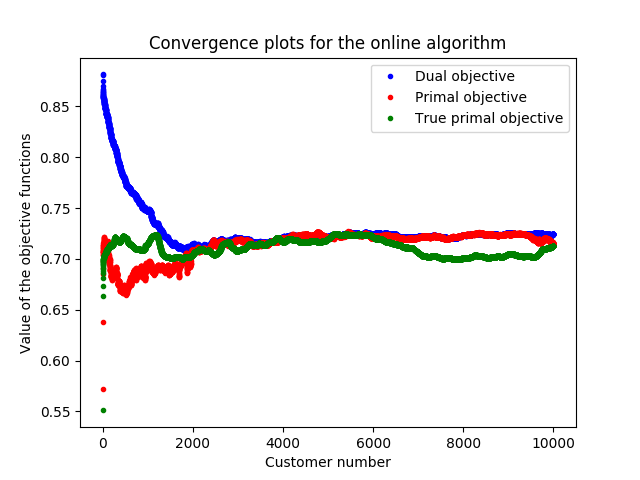

In [22]:
plt.figure()
plt.title('Convergence plots for the online algorithm')
plt.xlabel('Customer number')
plt.ylabel('Value of the objective functions')
plt.plot((np.array(listdual)),'b.',label='Dual objective')
plt.plot((np.array(listprimal)),'r.',label='Primal objective')
plt.plot((np.array(listtrueprimal)),'g.',label='True primal objective')
plt.legend()

In [13]:
lambdastoys(next_Lambda)

array([[8.41555894e-01, 1.58444097e-01, 8.32510288e-09, 2.15635410e-11],
       [2.66128926e-11, 4.02363726e-01, 8.53503350e-12, 5.97636274e-01],
       [2.21926116e-33, 9.68687985e-07, 9.99999031e-01, 2.07255814e-25],
       [9.72056674e-19, 6.37208391e-01, 3.61598639e-01, 1.19297029e-03],
       [2.64831096e-15, 9.99864705e-01, 1.35294575e-04, 5.64680629e-29]])

In [14]:
print(np.sum(arrival_rates.reshape(m,1)/(np.sum(arrival_rates))*lambdastoys(init_Lambda)*true_prob_type,axis=0)*N)
print(np.sum(arrival_rates.reshape(m,1)/(np.sum(arrival_rates))*lambdastoys(current_Lambda)*true_prob_type,axis=0)*N)
print(np.sum(arrival_rates.reshape(m,1)/(np.sum(arrival_rates))*lambdastoys([0.9,0.9,0.5,0.5])*true_prob_type,axis=0)*N)
print(np.sum(arrival_rates.reshape(m,1)/(np.sum(arrival_rates))*lambdastoys([1,1,1,1])*true_prob_type,axis=0)*N)


print(budget)

[1472.24640148 1648.12427249 1445.61207983  944.51690419]
[1490.03874289 2878.04675005 2184.7153299   605.39005048]
[3.76450836e-08 6.00254278e-09 4.97302633e+03 1.01120070e+03]
[1472.24640148 1648.12427249 1445.61207983  944.51690419]
[1701.08992295 2942.93963645 2286.12485    1780.48361719]


## A posteriori offline problem solution (for benchmark)

Iteration:  0
Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
Iteration:  500
Iteration:  600
Iteration:  700
Iteration:  800
Iteration:  900
Iteration:  1000
Iteration:  1100
Iteration:  1200
Iteration:  1300
Iteration:  1400
Iteration:  1500
Iteration:  1600
Iteration:  1700
Iteration:  1800
Iteration:  1900
Iteration:  2000
Iteration:  2100
Iteration:  2200
Iteration:  2300
Iteration:  2400
Iteration:  2500
Iteration:  2600
Iteration:  2700
Iteration:  2800
Iteration:  2900
Iteration:  3000
Iteration:  3100
Iteration:  3200
Iteration:  3300
Iteration:  3400
Iteration:  3500
Iteration:  3600
Iteration:  3700
Iteration:  3800
Iteration:  3900
Iteration:  4000
Iteration:  4100
Iteration:  4200
Iteration:  4300
Iteration:  4400
Iteration:  4500
Iteration:  4600
Iteration:  4700
Iteration:  4800
Iteration:  4900


<IPython.core.display.Javascript object>


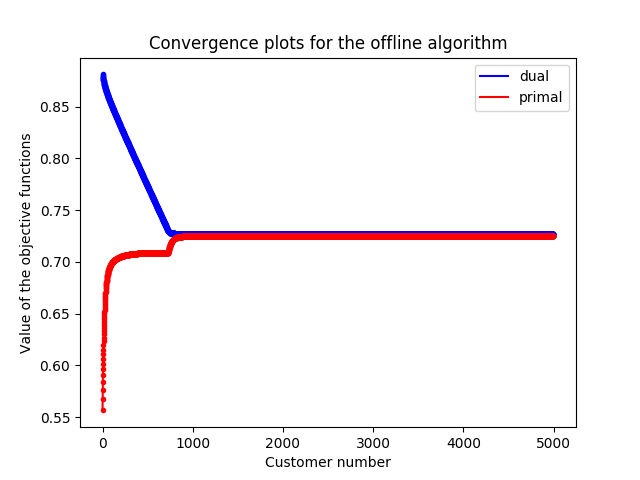

In [24]:
init_x=np.ones(d)#*0.1 # np.copy(current_Lambda)+0.05 #np.copy(current_Lambda) #initial value of the dual variable
ball_size = 5e-1 #used to set step size
maxgradnorm=0.0 #maximum value of the norm of the gradient
maxiter=5000

next_x=np.copy(init_x) #used for the looping

def f_k(x):
    #Dual problem objective function
    star=0
    for j in range(0,m):
        pj=true_prob_type[j] #selected row of pij matrix - for a given customer type j
        pjmax=np.max(pj)
        a=np.max(pj*(r-x)/(pjmax*mu))
        modtermj=a+np.log(np.sum(np.exp(pj*(r-x)/(pjmax*mu)-a)))
        starj=modtermj*true_arrival_rates[j]/np.sum(true_arrival_rates)*pjmax
        star+=starj
    return mu*star+np.dot(x,budget)/N


def partialderivative(x,i,deltay):
    #Calculating partial derivative of the dual problem objective function w.r.t. particular item
    y=np.copy(x)
    y[i]=y[i]+deltay
    fk_y=f_k(y)
    fk_x=f_k(x)
    return (fk_y-fk_x)/deltay

def explicitpartialderivative(Lambda,i):
    star=0
    for j in range(0,m):
        pj=true_prob_type[j]
        pjmax=np.max(pj)
        if pjmax==0:
            pjmax=np.min(true_prob_type[true_prob_type>0])
        a=np.max(pj*(r-Lambda)/(pjmax*mu))
        starj=true_arrival_rates[j]/np.sum(true_arrival_rates)*pj[i]*np.exp((r[i]-Lambda[i])*pj[i]/(pjmax*mu)-a)/np.sum(np.exp((r-Lambda)*pj/(pjmax*mu)-a))
        star+=starj
    return -star+budget[i]/N


def lambdastoys(x):
    ylist=[]
    for j in range(0,m):
        pj=true_prob_type[j]
        pjmax=np.max(pj)
        a=np.max(pj*(r-x)/(pjmax*mu))
        v=pj*(r-x)/(pjmax*mu)-a-np.log(np.sum(np.exp(pj*(r-x)/(pjmax*mu)-a)))
        y=np.exp(v)
        ylist.append(y)
    return np.array(ylist) #should be a vector with length n

def primal(x):
    return np.sum(np.array([r[i]*true_prob_type[j,i]*lambdastoys(x)[j,i]*true_arrival_rates[j] for j in range(m) for i in range(d)]))
####################

listdual_offline=[]
listprimal_offline=[]

for iteration in range(0,maxiter): #going through each newly arriving customer
    
    if iteration%100==0:
        print('Iteration: ',iteration)
    
    #gradient descent code to update Lambdas based on the previous data (customer yet haven't arrived)
    #######################################
    gradlist=[] 
    current_x=next_x

    for i in range(0,d):
        if next_x[i]!=0.0: 
            gradlist.append(explicitpartialderivative(current_x,i)) 
        else:
            gradlist.append(0.0)
    grad=np.array(gradlist)
    gradnorm=np.linalg.norm(grad)

    if gradnorm>maxgradnorm:
        maxgradnorm=gradnorm
            
    next_x = current_x - ball_size*grad/(maxgradnorm*np.sqrt(n+1)) #updating Lambda using L-Lipshitz smoothness
    next_x[next_x<0]=0.0 #proximal setting
    
    listdual_offline.append(f_k(current_x)) #used for plotting
    listprimal_offline.append(primal(current_x))
    

plt.figure()  
plt.title('Convergence plots for the offline algorithm')
plt.xlabel('Customer number')
plt.ylabel('Value of the objective functions')
plt.plot(listdual_offline,'b.')
plt.plot(listdual_offline,'b',label='dual')
plt.plot(listprimal_offline,'r.')
plt.plot(listprimal_offline,'r',label='primal')
plt.legend()

In [16]:
np.set_printoptions(suppress=True)
print(next_Lambda)
print(lambdastoys(next_Lambda))
print(primal(next_Lambda))

[0.19543094 0.05386122 0.1029872  0.        ]
[[0.52360518 0.47639482 0.         0.        ]
 [0.         0.90094803 0.         0.09905197]
 [0.0000002  0.00000019 0.99999961 0.        ]
 [0.         0.43582367 0.56134717 0.00282916]
 [0.         0.99999868 0.00000132 0.        ]]
0.7168801788214592


In [17]:
print(next_x)
print(lambdastoys(next_x))
print(primal(next_x))

[0.09466053 0.06577683 0.12314471 0.        ]
[[0.9999861  0.0000139  0.         0.        ]
 [0.00000002 0.73423995 0.         0.26576003]
 [0.01653715 0.00000054 0.98346231 0.        ]
 [0.         0.6454299  0.34164511 0.01292499]
 [0.         0.9999993  0.0000007  0.        ]]
0.7252559862448924


In [18]:
REGdual=np.sum(np.abs(np.array(listdual)-f_k(np.array(next_x))))/N
#REGprimal=(np.sum(np.array(listprimal)-primal(next_x)))/N
print('REGRET dual: ',REGdual)
#print('REGRET primal: ',REGprimal)

REGRET dual:  0.011354189248162047


In [19]:
combinedregret=REGdual+modregretUCB_sum/N
print(combinedregret)

0.020032539138147648
